<a href="https://colab.research.google.com/github/NOBODIDI/APS360_GeoGuessr_NN/blob/main/testing/Distance_Computation_and_Visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Useful Links

*   Background info: https://cs231n.github.io/transfer-learning/
*   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


REMEMBER TO CHANGE RUNTIME TO GPU AND THEN MOUNT GOOGLE DRIVE (ALSO ADD TRAIN_VAL_TEST_SPLIT AS A SHORTCUT TO DRIVE)

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import time
import copy

# For geographical distance computation
import geopy
from geopy.distance import great_circle 

# CSV
import csv

### Initializing Model

#### Datasets and Dataloaders (Run ONCE)

In [ ]:
# Loading in Data

# /////////// CHANGE THIS TO TRUE IF YOU WANT TO USE INCEPTION /////////
is_inception = False
# /////////////////////////////////////////////////////////
if is_inception:
    resize = 342
    input_size = 299
else:
    resize = 256
    input_size = 224

# Data augmentation and normalization for training
# Just normalization for validation, test

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(resize),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# ////////////////// CHANGE THIS IF NEEDED TO POINT TO THE DATA ////////////////////////
root_path = "/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/32k_train_val_test"
# ////////////////////////////////////////////////////////////////////////////////

# Fixed PyTorch random seed for reproducible result
torch.manual_seed(1000)

# Create training and validation and test datasets
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(root_path, x), 
                                                      data_transforms[x]) for x in ['train', 'val','test']}

classes = image_datasets['train'].classes
# Number of classes
num_classes = len(classes)
print("Total dataset:",len(image_datasets['train'])+len(image_datasets['val'])+len(image_datasets['test']),"\n",
      "\tTrain size:",len(image_datasets['train']),"\n\tVal size:",len(image_datasets['val']),"\n\tTest size:",len(image_datasets['test']))
print("Number of classes:",num_classes)

batch_size = 64
# Create training and validation and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, 
                                                   shuffle=True, num_workers=1) for x in ['train', 'val','test']}

Total dataset: 32000 
 	Train size: 22400 
	Val size: 4800 
	Test size: 4800
Number of classes: 80


# Import Trained Model Weights

In [ ]:
# Path to model with the hightest preliminary training accuracy
model_path = "/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/Hyperparameter Tuning/ResNet50 Results/Best model/best_32k_unfrozen_model_resnet50_bs64_lr0.001_ht10_wd1e-06_epochs40"

# Create model instance
trained_model = models.resnet50(weights='DEFAULT')
num_ftrs = trained_model.fc.in_features
trained_model.fc = nn.Linear(num_ftrs, 80)

# Load trained weights
trained_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

## Testing Model


In [ ]:
def test_model(model, 
               datasets=image_datasets, 
               batch_size=256 ):
  
    since = time.time()
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 
                                                  batch_size=batch_size, 
                                                  shuffle=True, 
                                                  num_workers=1) for x in ['test']}

    model.eval()   # Set model to evaluate mode
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders['test']:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          model = model.cuda()
          inputs = inputs.cuda()
          labels = labels.cuda()
        #############################################

        # Get model outputs and calculate loss
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    test_acc = float(running_corrects) / len(dataloaders['test'].dataset)

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(test_acc))

    return

# Testing Model

In [ ]:
# Run on GPU
use_cuda = True
if use_cuda and torch.cuda.is_available():
  trained_model = trained_model.cuda()
  print('CUDA is available!  Running on GPU ...')
else:
  print('CUDA is not available.  Running on CPU ...')

test_model(trained_model, datasets=image_datasets, batch_size=64)



CUDA is not available.  Running on CPU ...
Testing complete in 25m 35s
Test Acc: 0.413125


# Define Distance Evaluator Function
This function returns the distance between two cordinates (latitude, longitude)

In [ ]:
# Reading the CSV and construct dictionary for geocell centre look-up
################################### Replace hyperlink to csv file path #################################################
csv_path = '/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/processed_geocells_final.csv'
########################################################################################################################
# Initialise empty dictionary
class_centre_dict={}

with open(csv_path,'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',') 
  counter=1
  for row in csv_reader:
    if counter!=1:
      class_centre_dict[int(row[0])]=[float(row[5]),float(row[6])]
    counter+=1

# Put the lats and lons of each geocell centre into separate lists, ordered by
# the order of the classes in the torch model outputs; convert the lists to tensors
geocell_lats = [class_centre_dict[int(geocell_id)][0] for geocell_id in classes]
geocell_lons = [class_centre_dict[int(geocell_id)][1] for geocell_id in classes]
geocell_lats = torch.Tensor(geocell_lats).unsqueeze(0)
geocell_lons = torch.Tensor(geocell_lons).unsqueeze(0)

# Reading the filename to image coordinates dictionary
################################### Replace hyperlink to csv file path #################################################
csv_path = '/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/imagery_locations_merged.csv'
########################################################################################################################
# Initialise empty dictionary
image_location_dict={}

with open(csv_path,'r') as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',') 
  counter=1
  for row in csv_reader:
    if counter!=1:
      image_location_dict[row[1]]=[float(row[2]),float(row[3])]
    counter+=1


In [ ]:
def model_distance(model, image_path, image_filename, true_class, print_results=True):
    #def model_distance(model, root_path, dataset, true_class, image_filename):
    '''
    This function computes the distance of between the center of the model's prediction class and the image's true location given its filename and specified folders

    Dataset sor can be either 'test', 'val', or 'train'
    '''
    model.eval()

    ###################### GENERATE PATH #############################
    #image_path = os.path.join(root_path, dataset, true_class, image_filename)
    image = plt.imread(image_path,0)
    # Repeat dataset transforms
    transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize(256), 
                                transforms.CenterCrop(224), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    # Apply transforms
    image_torch = transform(image)
    # # Converts tensor dimensions C,W,H -> W,H,C
    # image_torch.permute(1, 2, 0)
    # plt.imshow(image_torch)
    # Convert 3D tensor -> 4D tensor
    image_torch = image_torch.unsqueeze(0)

    # Get raw model outputs
    outputs = model(image_torch)
    outputs = F.softmax(outputs, dim=1) # probs now all sum to 1 and in range of [0,1]

    if print_results:
        print(f'True geocell of image: {true_class}')

    # Basic method: taking centre of output class with highest probability
    predicted_class = classes[outputs.argmax(dim=1)]
    predicted_prob = torch.max(outputs, dim=1).values.item()
    centre_of_prediction_class = class_centre_dict.get(int(predicted_class))
    if print_results:
        print(f'Predicted geocell with highest probability: {predicted_class} with confidence {predicted_prob:.4f}')
        # print(f'Predicted image location as centre of most likely geocell: {centre_of_prediction_class}')

    # More complex method: taking the weighted average of centres of all classes,
    # based on predicted probabilities 
    # Take weighted sum of all lats (element-wise mult between probs and lats)
    predicted_avg_lat = torch.mul(outputs, geocell_lats).sum(dim=1)
    predicted_avg_lon = torch.mul(outputs, geocell_lons).sum(dim=1) # repeat for lons
    predicted_avg_location = [predicted_avg_lat[0].item(), predicted_avg_lon[0].item()]
    if print_results:
        # print(f'Predicted image location as weighted average of all geocell centres: {predicted_avg_location}')
        print(f'Predicted image location: {predicted_avg_location}')

    # Retrieve image location
    image_location = image_location_dict.get(image_filename)
    if print_results:
        print(f'True location of image: {image_location}')

    # Calculate distance errors
    distance_centre = great_circle(centre_of_prediction_class, image_location).km
    distance_weighted = great_circle(predicted_avg_location, image_location).km

    if print_results:
        # print(f'Distance error to centre of most likely geocell: {distance_centre:.2f} km')
        # print(f'Distance error to weighted average of all geocell centres: {distance_weighted:.2f} km')
        print(f'Distance error: {distance_weighted:.2f} km')

    map_vis = create_output_visualization(outputs, true_class, 
                                          centre_of_prediction_class, 
                                          predicted_avg_location, image_location)

    return map_vis, int(predicted_class), distance_centre, distance_weighted, predicted_avg_location


In [ ]:
import folium
import pandas as pd
from IPython.display import display

geocells = pd.read_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/processed_geocells_final.csv')

def create_output_visualization(outputs, true_class, predicted_centre, predicted_weighted, true_loc):

    m = folium.Map(location=[44.967243, -103.771556], zoom_start=3, tiles='cartodb positron')

    for i, geocell_prob in enumerate(outputs[0]):
        prob_class = int(classes[i])
        geocell_info = geocells[geocells['geocell_id'] == prob_class].squeeze()

        # draw geocell rectangle
        folium.vector_layers.Rectangle(
            bounds=[
                (geocell_info['lat_top'], geocell_info['lon_left']),
                (geocell_info['lat_top'], geocell_info['lon_right']),
                (geocell_info['lat_bottom'], geocell_info['lon_right']),
                (geocell_info['lat_bottom'], geocell_info['lon_left'])
            ], 
            color='gray', fill=True, fill_color='green', 
            fill_opacity=geocell_prob.item() * 0.7, 
            tooltip=f'ID: {prob_class}; prob: {geocell_prob * 100:.2f}%').add_to(m)
        
    # add markers for true location and the two guesses
    sv_url = f'<a href=http://maps.google.com/maps?q=&layer=c&cbll={true_loc[0]},{true_loc[1]} target=_blank>' \
             f'{true_loc[0]},{true_loc[1]}</a>'
    folium.Marker(location=true_loc, 
                  icon=folium.Icon(color='black', icon='flag'), 
                  tooltip='True Location', popup=sv_url).add_to(m)
    # folium.Marker(location=predicted_centre, 
    #               icon=folium.Icon(color='red'), 
    #               tooltip='Predicted Location (Centre)').add_to(m)
    folium.Marker(location=predicted_weighted, 
                  icon=folium.Icon(color='orange'), 
                  tooltip='Predicted Location (Weighted)').add_to(m)

    # add lines from guesses to true location
    # folium.vector_layers.PolyLine(locations=[true_loc, predicted_centre], color='red').add_to(m)
    folium.vector_layers.PolyLine(locations=[true_loc, predicted_weighted], color='orange').add_to(m)

    return m

In [ ]:
# ----- Tests (Don't need to run this for demo) ------

root_path = '/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/32k_train_val_test/test'

# define tests as a list of tuples of (true class, filename without extension) 
tests = [
    # (100, '-0VT1h4kR6JMngUUTkFCrQ'),
    # (41, 'bZEnG1EgWjUfsvzrJpvQTQ'),
    # (206, 'Q5IA8WBh9YDoDhA8GWuogQ'),
    # (66, 'Drojr30vColtzLzVGSzHbg'),
    # (93, 'lqxGPPDv1S49MBF-fbA6Yw'),
    # (114, 'K5gYX0MYXlcwiqBYTZKXVQ'),
    (22, '-Gr7SS91nEotBWPs7OSqGw'),
    # (22, 'rlCnuV5ZRD1wEUUL6TBIbg')
]

for i, test in enumerate(tests):
    print(f'----- Test {i+1} -----')
    image_path = root_path + f'/{test[0]}/{test[1]}.png'
    map_vis, _, _, _, _ = model_distance(trained_model, image_path, test[1], test[0])
    print()
    display(map_vis)


# Demo

### Look Up Image IDs from Test Lat/Lons

In [ ]:
import pandas as pd

img_metadata_db = pd.read_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/imagery_locations_32k_test.csv')
root_path = '/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/32k_train_val_test/test'
# img_metadata_db = pd.read_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/imagery_locations_test_new.csv')
# root_path = '/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/dataset4_28000'

use_random = False

if not use_random:

    # ///////////////////////////////////////////////////////////////
    # Enter lat/lon of test locations from Google Maps / GeoGuessr 
    # ///////////////////////////////////////////////////////////////
    test_latlons = [
        (34.575479,-100.954848), # Location 0
        (46.22356,-105.685128), # Location 1
        (17.10401,-96.847175), # Location 2
        (45.941962,-87.207782), # Location 3
        (34.768993,-81.017117), # Location 4
        (36.096242,-111.357211), # 5
        (47.001163,-54.136505), # 6
        (51.270838,-107.78829), # 7
        (16.690046,-92.017375), # 8
        (46.246886,-94.973527), # 9
    ]

    test_imgs = []

    for lat, lon in test_latlons:
        # get closest match in terms of coordinates
        img_metadata_db['coords_diff'] = (img_metadata_db['img_lat'] - lat).abs() + \
                                        (img_metadata_db['img_lon'] - lon).abs()
        img_row = img_metadata_db[img_metadata_db['coords_diff'] == img_metadata_db['coords_diff'].min()].squeeze()
        test_imgs.append((img_row['geocell_id'], img_row['pano_id']))

else:

    # OR use random test images
    # random_df = img_metadata_db.sample(50, ignore_index=True) # randomly sample some images from set
    random_df = img_metadata_db.copy() # use all images
    test_imgs = list(zip(random_df['geocell_id'].tolist(), random_df['pano_id'].tolist()))


To save any generated random set:

In [ ]:
random_df.to_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/rand50_2.csv', index=False)

### Get Model Predictions and Results


#### Small dataset / individual map visualizations:

In [ ]:
# PARAMETERS
run_aggregate = False

# ------------------------- Get Aggregate Results ------------------------------
if run_aggregate:

    import statistics as st

    correct_class_count = 0
    distance_errors_centre = []
    distance_errors_weighted = []

    for img_class, img_id in test_imgs:
        image_path = root_path + f'/{img_class}/{img_id}.png'
        _, predicted_class, distance_centre, distance_avg, _ = model_distance(trained_model, image_path, img_id, img_class, print_results=False)

        correct_class_count += int(img_class == predicted_class)
        distance_errors_centre.append(distance_centre)
        distance_errors_weighted.append(distance_avg)

    print('----- Aggregate Statistics -----')
    print(f'Number of locations: {len(test_imgs)}')
    print(f'Correctly predicted classes: {correct_class_count} out of {len(test_imgs)}')
    # print(f'Total distance error (centre): {sum(distance_errors_centre):.2f} km')
    print(f'Total distance error: {sum(distance_errors_weighted):.2f} km')
    # print(f'Average distance error per location (centre): {st.mean(distance_errors_centre):.2f} km')
    print(f'Average distance error per location: {st.mean(distance_errors_weighted):.2f} km')
    # print(f'Max distance error per location (centre): {max(distance_errors_centre):.2f} km')
    print(f'Max distance error per location: {max(distance_errors_weighted):.2f} km (location {np.argmax(distance_errors_weighted)})')
    # print(f'Min distance error per location (centre): {min(distance_errors_centre):.2f} km')
    print(f'Min distance error per location: {min(distance_errors_weighted):.2f} km (location {np.argmin(distance_errors_weighted)})')
    # print(f'Median distance error per location (centre): {st.median(distance_errors_centre):.2f} km')
    print(f'Median distance error per location: {st.median(distance_errors_weighted):.2f} km')
    print()

# ------------------------- View Results One-by-One ----------------------------
if not run_aggregate:

    cur_test_index = 4 # ////// Change this to view results of each test image in the defined set
    cur_test_img_class = test_imgs[cur_test_index][0]
    cur_test_img_id = test_imgs[cur_test_index][1]

    print(f'----- Results for Location {cur_test_index} -----')
    print(f'Image ID: {cur_test_img_id}')
    image_path = root_path + f'/{cur_test_img_class}/{cur_test_img_id}.png'
    map_vis, _, _, _, _ = model_distance(trained_model, image_path, cur_test_img_id, cur_test_img_class)
    print()
    display(map_vis)

----- Results for Location 4 -----
Image ID: 5qtovFnd3pSK0wYn7uDq8g
True geocell of image: 138
Predicted geocell with highest probability: 87 with confidence 0.5049
Predicted image location: [42.43564224243164, -74.0517349243164]
True location of image: [34.768993, -81.017117]
Distance error: 1044.67 km



#### Large dataset - results stored to file

In [ ]:
from tqdm import tqdm

demo_output = random_df.copy()
demo_output['predicted_geocell'] = 0 # initialize column in order to use int datatype

for i in tqdm(range(len(demo_output))):
    img_row = demo_output.iloc[i].squeeze()
    img_class = img_row['geocell_id']
    img_id = img_row['pano_id']

    image_path = root_path + f'/{img_class}/{img_id}.png'
    _, predicted_class, _, distance_avg, pred_loc = model_distance(trained_model, image_path, img_id, img_class, print_results=False)
    demo_output.loc[i, 'predicted_geocell'] = predicted_class
    demo_output.loc[i, 'predicted_lat'] = pred_loc[0]
    demo_output.loc[i, 'predicted_lon'] = pred_loc[1]
    demo_output.loc[i, 'distance_error'] = distance_avg

demo_output['distance_error'] = demo_output['distance_error'].round(2)

demo_output.to_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/new_test_all_results.csv', index=False)

100%|██████████| 4800/4800 [43:43<00:00,  1.83it/s]


Aggregate statistics and visualizations:

In [ ]:
import pandas as pd
from IPython.display import display

demo_output = pd.read_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/32k_test_all_results.csv')

Histogram of distance errors:

Total number of locations tested: 4800
Average: 748.44 km
Minimum: 1.18 km
Maximum: 5326.23 km
Median: 485.93 km


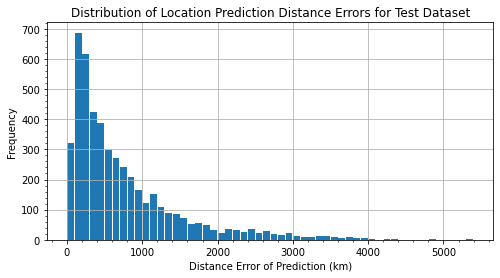

In [ ]:
print(f'Total number of locations tested: {len(demo_output)}')
print(f"Average: {demo_output['distance_error'].mean():.2f} km")
print(f"Minimum: {demo_output['distance_error'].min()} km")
print(f"Maximum: {demo_output['distance_error'].max()} km")
print(f"Median: {demo_output['distance_error'].median()} km")

BIN_WIDTH = 100
ceiling = (int(demo_output['distance_error'].max() / BIN_WIDTH) + 1) * BIN_WIDTH # round up max value to the nearest multiple of BIN_WIDTH

plt.figure(figsize=(8, 4), dpi=72)
ax = plt.gca()
_, bins, _ = plt.hist(demo_output['distance_error'], bins=int(ceiling / BIN_WIDTH), range=(0, ceiling), rwidth=0.9)
# bins
plt.xlabel('Distance Error of Prediction (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Location Prediction Distance Errors for Test Dataset')
plt.grid(True)
ax.minorticks_on()

# plt.savefig('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/final_representative_tests/32k_test_histogram.png')

Map visualization of geocell relative prediction error frequency:

In [ ]:
import branca

demo_output['is_correct'] = (demo_output['geocell_id'] == demo_output['predicted_geocell'])
print(demo_output['is_correct'].sum())
wrong_pred = demo_output.groupby('geocell_id')['is_correct'].apply(lambda x: 1 - (x.sum() / len(x)))
wrong_pred = wrong_pred.sort_values(ascending=False)
wrong_pred = (wrong_pred - wrong_pred.min()) / (wrong_pred.max() - wrong_pred.min()) # normalize to between 0 and 1
wrong_pred = wrong_pred.round(4)
# wrong_pred

geocells = pd.read_csv('/content/drive/MyDrive/APS360 - Deep Learning Project /Colab Notebooks/processed_geocells_final.csv')

m = folium.Map(location=[44.967243, -103.771556], zoom_start=3, tiles='cartodb positron')

colormap = branca.colormap.linear.YlOrRd_09.scale(wrong_pred.min(), wrong_pred.max(), max_labels=5)
colormap.caption = 'Normalized Relative Class Prediction Error Rate'

for i, geocell_info in geocells.iterrows():
    # draw geocell rectangle
    folium.vector_layers.Rectangle(
        bounds=[
            (geocell_info['lat_top'], geocell_info['lon_left']),
            (geocell_info['lat_top'], geocell_info['lon_right']),
            (geocell_info['lat_bottom'], geocell_info['lon_right']),
            (geocell_info['lat_bottom'], geocell_info['lon_left'])
        ], 
        color='gray', fill=True, fill_color=colormap(wrong_pred[int(geocell_info['geocell_id'])]), 
        fill_opacity=0.6, 
        tooltip=f"ID: {int(geocell_info['geocell_id'])}; normalized error rate: {wrong_pred[geocell_info['geocell_id']]}").add_to(m)

colormap.add_to(m)

m

1299
